## 0. 사전 작업

In [1]:
!pip install gradio #gradio install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [2]:
!pip install mediapipe #mediapipe install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 46.7 MB/s eta 0:00:00


In [3]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
import torch
from torchvision.transforms import ToTensor
from torchvision.models import densenet
from torchvision import transforms
import torchvision
from tensorflow.keras.models import Model
import math
import cv2 as cv
import os
import mediapipe as mp
import pandas as pd
from google.colab.patches import cv2_imshow as cv_imshow
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import vgg16

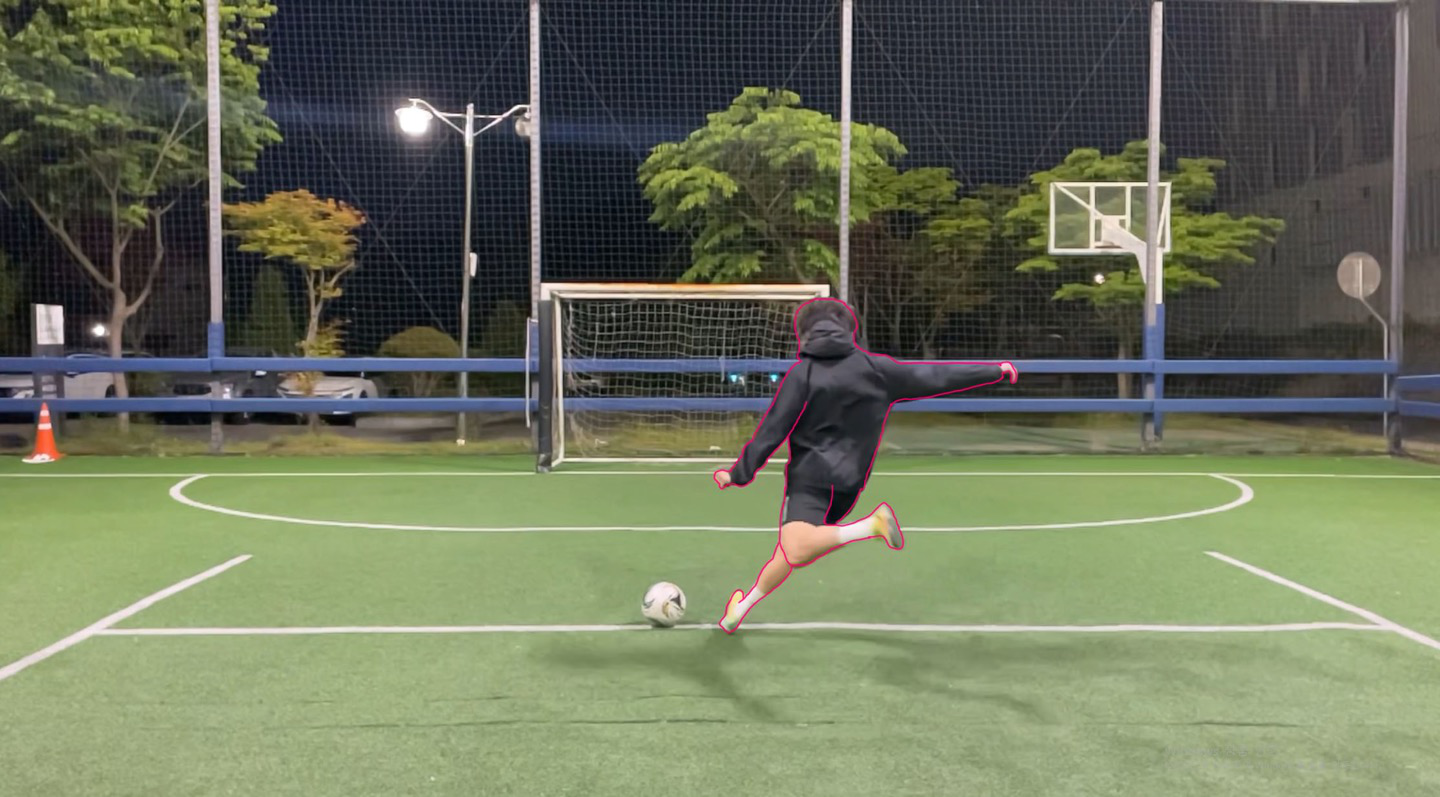

In [4]:
# 홈페이지에 사용될 함수가 잘 작동하는지 테스트할 이미지 선언
image_path = "/content/drive/MyDrive/Colab_Notebooks/ML_2023/data/images/kick5.jpg"  # 이미지 파일 경로
test_image = Image.open(image_path)
test_image

In [5]:
#모델의 input으로 들어가기 전 이미지에 실행되는 전처리 과정
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(0,15)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
])

In [6]:
example = test_image.convert("RGB")
trans_example = transform(example)
example = ToTensor()(trans_example).unsqueeze(0)

## 1. Densenet 홈페이지

In [9]:
densenet_path = '/content/drive/MyDrive/Colab_Notebooks/ML_2023/data/parameters/final_densenet.pth'  # densenet 파일의 경로로 수정
state_dict = torch.load(densenet_path, map_location=torch.device('cpu'))

In [10]:
#pth 파일을 넣기 위한 기본 틀 선언
densenet_model = densenet.densenet121(pretrained=False)
densenet_model.features.conv0 = torch.nn.Conv2d(in_channels= 3,  out_channels=64, kernel_size=7)
densenet_model.classifier = torch.nn.Linear(in_features= 1024, out_features= 2, bias= True)
densenet_model.load_state_dict(state_dict)
densenet_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [11]:
# densenet을 이용한 라벨 예측 함수
def predict_image_with_densenet(img):
    img = img.convert("RGB")
    img = transform(img)
    img = ToTensor()(img).unsqueeze(0)
    output = densenet_model(img)
    S = torch.nn.Softmax(dim = 1)
    output = S(output)
    return {'정상': float(1-output[0][0]), '비정상': float(output[0][0])}

In [12]:
# 함수 테스트
res = predict_image_with_densenet(test_image)
print(res)

{'정상': 0.9981589913368225, '비정상': 0.0018409858457744122}


In [13]:
# gradio를 이용한 홈페이지 제작
inputs = gr.inputs.Image(type = 'pil')
label = gr.outputs.Label()
interface = gr.Interface(fn=predict_image_with_densenet, inputs=inputs, outputs=label,
             title='킥 자세 판단',
             description='미리 학습시킨 densenet 모델을 사용하여 킥 자세를 판단합니다.')
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 2. Resnet 홈페이지

In [14]:
resnet_path = '/content/drive/MyDrive/Colab_Notebooks/ML_2023/data/parameters/final_resnet.pth'  # resnet 파일의 경로로 수정
state_dict = torch.load(resnet_path, map_location=torch.device('cpu'))

In [15]:
#pth 파일을 넣기 위한 기본 틀 선언
resnet_model = torchvision.models.resnet101()
resnet_model.fc = torch.nn.Linear(in_features =2048, out_features=2, bias = True)
resnet_model.load_state_dict(state_dict, strict=False) # strict를 추가해줘야 합니다
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# resnet을 이용한 라벨 예측 함수
def predict_image_with_resnet(img):
    img = img.convert("RGB")
    img = transform(img)
    img = ToTensor()(img).unsqueeze(0)
    output = resnet_model(img)
    S = torch.nn.Softmax(dim = 1)
    output = S(output)
    return {'정상': float(1-output[0][0]), '비정상': float(output[0][0])}

In [17]:
# 함수 테스트
res = predict_image_with_resnet(test_image)
print(res)

{'정상': 1.0, '비정상': 7.187453743284777e-09}


In [18]:
# gradio를 이용한 홈페이지 제작
inputs = gr.inputs.Image(type = 'pil')
label = gr.outputs.Label()
interface = gr.Interface(fn=predict_image_with_resnet, inputs=inputs, outputs=label,
             title='킥 자세 판단',
             description='미리 학습시킨 resnet 모델을 사용하여 킥 자세를 판단합니다.')
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 3. 회색 배경 홈페이지

In [43]:
# 회색 배경 만들어주는 함수
# 주의해야 할 사항이 있다면, cv 라이브러리를 활용하기 위한 input image 형태는 PIL이 아닌 numpy 배열입니다!
# gradio를 통해 제작된 홈페이지에 출력되기 때문에 return 시 다시 PIL 형태로 변환해주어야 합니다.
def draw_gray(img):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    contrast = 0.75
    brightness = 1.5
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        static_image_mode = True,
        enable_segmentation=True,
    ) as pose:
        np_img = np.array(img)
        cv_img = cv.convertScaleAbs(np_img, alpha = contrast, beta = brightness)
        results = pose.process(cv.cvtColor(cv_img, cv.COLOR_BGR2RGB))
        annotated_image = cv_img.copy()
        condition = np.stack((results.segmentation_mask,) * 3, axis = -1) >0.1
        bg_image = np.zeros(cv_img.shape, dtype = np.uint8)
        bg_image[:] = (192,192,192) #배경 회색으로 처리
        annotated_image = np.where(condition, annotated_image, bg_image)
        res = Image.fromarray(annotated_image)
    return res

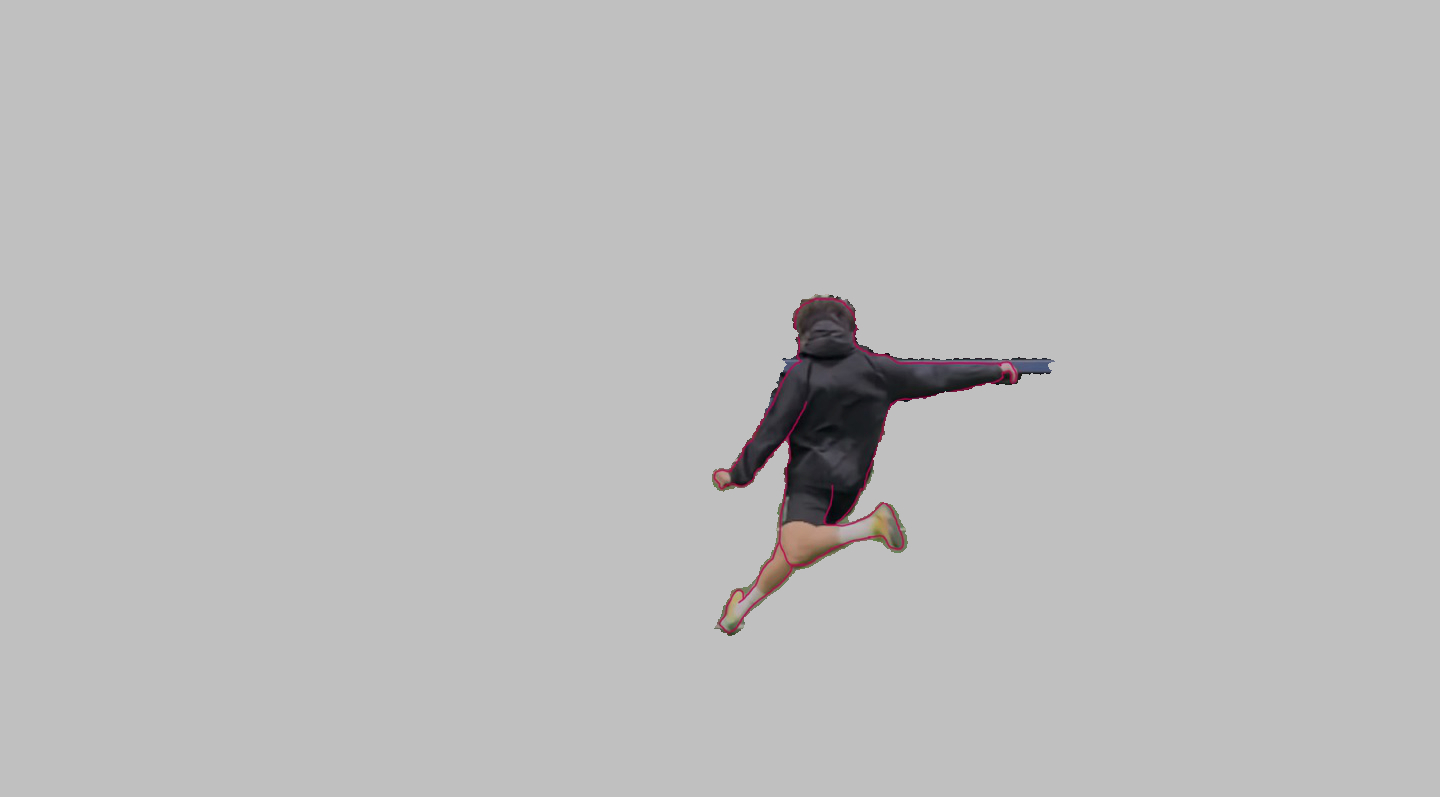

In [44]:
#테스트 이미지로 함수 출력 확인
a = draw_gray(test_image)
a

In [45]:
# 회색 배경 만들어주는 홈페이지 제작
inputs = gr.inputs.Image(type = 'pil')
outputs = gr.outputs.Image(type = 'pil')
interface = gr.Interface(fn=draw_gray, inputs=inputs, outputs=outputs,
             title='회색 배경 그려주기',
             description='mediapipe를 활용하여 배경을 회색 처리합니다.')
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 4. landmark 홈페이지

In [46]:
# landmark 그려주는 홈페이지
# 이미지 파일 형태의 변환 과정은 이전 회색 배경 홈페이지와 같습니다.
def draw_landmarks(img):
    np_img = np.array(img)
    height, width, _ = np_img.shape
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    bl_img = cv.GaussianBlur(np_img, (0, 0), 1)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        bl_img.flags.writeable = False
        bl_img = cv.cvtColor(bl_img, cv.COLOR_BGR2RGB)
        results = pose.process(bl_img)
        bl_img.flags.writeable = True
        bl_img = cv.cvtColor(bl_img, cv.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(
            bl_img,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    res = Image.fromarray(bl_img)
    return res

In [48]:
inputs = gr.inputs.Image(type = 'pil')
outputs = gr.outputs.Image(type = 'pil')
interface = gr.Interface(fn=draw_landmarks, inputs=inputs, outputs=outputs,
             title='랜드마크 그려주기',
             description='mediapipe를 사용하여 킥 자세의 랜드마크를 예측합니다.')
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 5.각도 출력 홈페이지

In [51]:
# 주어진 image의 scaled_list, shape을 활용해 5개의 각도 계산하는 클래스 선언
class calculator:
  def __init__(self, array, width, height):
    x1 = 0
    x2 = 0
    x3 = 0
    y1 = 0
    y2 = 0
    y3 = 0
    self.array = array
    self.width = width
    self.height = height
  def angle1(self):
    self.x1, self.y1 = self.array[12]
    self.x2, self.y2 = self.array[14]
    self.x3, self.y3 = [self.array[12][0],self.height]
    a1 = (self.y2 - self.y1) / (self.x2 - self.x1)
    a2 = (self.y3 - self.y1) / 1.0e-10
    a3 = (self.y3 - self.y2) / (self.x3 - self.x2)
    angle_rad1 = math.atan(abs((a1 - a3) / (1 + a1 * a3)))
    angle1 = math.degrees(angle_rad1)
    angle_rad2 = math.atan(abs((a3)))
    angle2 = 90 - math.degrees(angle_rad2)
    return 180 - angle1 - angle2
  def angle2(self):
    angle = 0
    return angle
  def angle3(self):
    self.x1, self.y1 = self.array[23]
    self.x2, self.y2 = self.array[25]
    self.x3, self.y3 = self.array[27]
    a1 = (self.y2 - self.y1) / (self.x2 - self.x1)
    a2 = (self.y3 - self.y2) / (self.x3 - self.x2)
    angle_rad = math.atan(abs((a1 - a2) / (1 + a1 * a2)))
    angle = math.degrees(angle_rad)
    return angle
  def angle4(self):
    self.x1, self.y1 = self.array[25]
    self.x2, self.y2 = self.array[27]
    self.x3, self.y3 = self.array[31]
    a1 = (self.y2 - self.y1) / (self.x2 - self.x1)
    a2 = (self.y3 - self.y2) / (self.x3 - self.x2)
    angle_rad = math.atan(abs((a1 - a2) / (1 + a1 * a2)))
    angle = math.degrees(angle_rad)
    return 180 - angle
  def angle5(self):
    self.x1, self.y1 = self.array[26]
    self.x2, self.y2 = self.array[30]
    self.x3, self.y3 = [self.array[26][0],self.array[30][1]]
    a1 = (self.y2 - self.y1) / (self.x2 - self.x1)
    a2 = (self.y3 - self.y2) / (self.x3 - self.x2)
    angle_rad = math.atan(abs((a1 - a2) / (1 + a1 * a2)))
    angle = math.degrees(angle_rad)
    return angle
  def angle6(self):
    self.x1, self.y1 = self.array[12]
    self.x2, self.y2 = self.array[24]
    self.x3, self.y3 = [self.array[12][0],self.array[24][1]]
    a1 = (self.y2 - self.y1) / (self.x2 - self.x1)
    a2 = (self.y3 - self.y2) / (self.x3 - self.x2)
    angle_rad = math.atan(abs((a1 - a2) / (1 + a1 * a2)))
    angle = math.degrees(angle_rad)
    return angle
  def values(self):
    a1 = self.angle1()
    a2 = self.angle2()
    a3 = self.angle3()
    a4 = self.angle4()
    a5 = self.angle5()
    a6 = self.angle6()
    ary = []
    ary.append(a1)
    ary.append(a3)
    ary.append(a4)
    ary.append(a5)
    ary.append(a6)
    return ary

In [52]:
# 이미지를 입력으로 넣으면 5개의 각도 값을 저장한 리스트를 반환하는 함수
def angle_of_image(img):
    np_img = np.array(img)
    height, width, _ = np_img.shape
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    df = pd.DataFrame()
    bl_img = cv.GaussianBlur(np_img, (0, 0), 1)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        bl_img.flags.writeable = False
        bl_img = cv.cvtColor(bl_img, cv.COLOR_BGR2RGB)
        results = pose.process(bl_img)
    res = results.pose_landmarks
    land_list = [[landmark.x, landmark.y] for landmark in res.landmark]
    scaled_list = []
    for (x, y) in land_list:
        x = round(x * width)
        y = round(y * height)
        scaled_list.append([x, y])
    cal = calculator(scaled_list, width = width, height = height)
    angle = cal.values()
    return angle

In [53]:
def print_angle2(img):
    np_img = np.array(img)
    height, width, _ = np_img.shape
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    bl_img = cv.GaussianBlur(np_img, (0, 0), 2)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        bl_img.flags.writeable = False
        bl_img = cv.cvtColor(bl_img, cv.COLOR_BGR2RGB)
        results = pose.process(bl_img)
        bl_img.flags.writeable = True
        bl_img = cv.cvtColor(bl_img, cv.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(
            bl_img,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    res = Image.fromarray(bl_img)
    std = [121.52797757176131,2.239210048225294,162.1627499966928,50.43494882292201,87.06432655357884]
    angle = angle_of_image(img)
    total = ""
    for cnt in range(5):
      if cnt == 0 :
        score = std[cnt] - angle[cnt]
        if abs(score) <= 5:
          total += "현재 팔과 어깨의 각도가 직각으로, 좋은 자세를 취하고 있습니다! \n"
        elif score > 0:
          total += "팔이 너무 위로 올라갔습니다. 킥을 찰 때 상체가 너무 기울어질 수 있으니 팔을 조금만 내려주세요! \n"
        elif score < 0:
          total += "팔이 너무 아래로 치우쳤습니다. 균형을 제대로 잡을 수 있도록 최대한 일자로 펴주세요! \n"

      if cnt == 1 :
        score = std[cnt] - angle[cnt]
        if abs(score) <= 20:
          total += "들어올리는 다리의 정도가 매우 좋은 것 같습니다. 슈팅이 잘 나오지 않는다면 발목의 각도나 다른 자세에 더 신경쓰는 것이 좋을 것 같습니다! \n"
        elif score > 0:
          total += "들어올리는 다리의 정도가 매우 좋은 것 같습니다. 슈팅이 잘 나오지 않는다면 발목의 각도나 다른 자세에 더 신경쓰는 것이 좋을 것 같습니다! \n"
        elif score < 0:
          total += " 다리를 너무 조금 들어올리는 것 같습니다. 공을 찰 때 힘을 실어주지 못해 공이 멀리 못나갈 가능성이 높으니, 뒷허벅지와 종아리 사이의 각도가 30~60도가 되도록 자신감 있게 다리를 더 들어올려주세요! \n"

      if cnt == 2 :
        score = std[cnt] - angle[cnt]
        if abs(score) <= 20:
          total += " 슈팅 하는 다리의 발과 정강이의 각도가 거의 수평을 이루고 있습니다! 부상의 위험도도 어느 때보다 낮으니 지금 자세를 유지해주세요! \n"
        elif score > 20:
          total += " 슈팅시 발목 각도가 매우 좋지 않습니다. 발목을 피지 않고 지금처럼 슈팅할시 발끝으로 공을 차, 발가락이나 발톱 부상이 발생할 수 있으니 발목이 정강이와 110도~수평을 이룰 수 있도록 신경써주세요! \n"
        elif score > 10:
          total += " 슈팅시 발목 각도가 좋지 않습니다. 목표 지점까지 공이 잘 날아가도록 실어줄 힘이 제대로 나오지 않아 좋지 않은 슈팅을 할 가능성이 높으니 디딤 다리와 최대한 170도가 되게 다리를 더 들어주세요. \n"
        else:
          total += " 슈팅 하는 다리의 발과 정강이의 각도가 거의 수평을 이루고 있습니다! 부상의 위험도도 어느 때보다 낮으니 지금 자세를 유지해주세요! \n"

      if cnt == 3 :
        score = std[cnt] - angle[cnt]
        if abs(score) <= 20:
          total += "발목과 지면 기준으로 45도를 잘 맞추고 있는 것 같습니다! 발목은 잘 다칠 수 있는 부위이니 연습 전 충분한 스트레칭을 해주세요.\n"
        elif score > 0:
          total += "발목이 너무 뻣뻣합니다! 발목 축을 안쪽으로 더 꺾어야할 것 같습니다.  발목 부상이 이뤄질 수 있으니 사전 스트레칭을 하고 진행해주세요! \n"
        elif score < 0:
          total += "발목이 너무 안쪽으로 꺾였습니다. 슈팅시 균형을 잃고 넘어질 수 있으니 발목 축을 조금 더 세우는 것이 좋을 것 같습니다! \n"

      if cnt == 4 :
        score = std[cnt] - angle[cnt]
        if abs(score) <= 20:
          total += "상체 각도를 잘 유지하고 있으니 다른 자세 개선에 더 신경써도 될 것 같습니다!\n"
        elif score > 0:
          total += "상체 각도를 잘 유지하고 있으니 다른 자세 개선에 더 신경써도 될 것 같습니다!\n"
        elif score < 0:
          total += "상체에 너무 많은 힘이 들어가 꼿꼿하게 서있는 것 같습니다. 상체에 긴장을 풀고 1번 기준을 잘 맞춘다면 자연스럽게 기준 6의 자세가 개선될 수 있을 것입니다!\n"

      total += "\n\n"

    return res,total

inputs = gr.inputs.Image(type = 'pil')
output_image = gr.outputs.Image(type = 'pil')
output_text = gr.outputs.Textbox()
interface = gr.Interface(fn=print_angle2, inputs=inputs, outputs=[output_image,output_text],
             title='피드백 해주기',
             description='계산한 각도를 사용하여 킥 자세의 피드백을 해줍니다.')
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 6. gradCAM

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab.patches import cv2_imshow
import os
import cv2
import glob
import numpy as np


class GradCam(nn.Module):
    def __init__(self, model, target_layer):
        super().__init__()
        self.model = model
        self.target_layer = target_layer
        self.register_hooks()

    def register_hooks(self):
        for name, module in self.model.named_modules():
            if module == self.target_layer:
              module.register_forward_hook(self.forward_hook)
              module.register_backward_hook(self.backward_hook)

    def forward(self, input, target_index):
        outs = self.model(input)
        outs = outs.squeeze()  # [1, num_classes]  --> [num_classes]

        # 가장 큰 값을 가지는 것을 target index 로 사용
        if target_index is None:
            target_index = outs.argmax()

        outs[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)         # [512, 1, 1]
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()                  # [512, 7, 7] * [512, 1, 1]
        out = torch.relu(out) / torch.max(out)  # 음수를 없애고, 0 ~ 1 로 scaling # [7, 7]
        out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])  # 4D로 바꿈
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])


if __name__ == '__main__':

    def show_cam_on_image(img, mask):

        # mask = (np.max(mask) - np.min(mask)) / (mask - np.min(mask))
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        cv2_imshow(np.uint8(255 * cam))
        cv2_imshow(np.uint8(heatmap * 255))
        cv2.waitKey()

def overlay_heatmap(image, heatmap, alpha=0.5):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlaid_image

In [24]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
target_layer = resnet_model.layer4[2].bn3

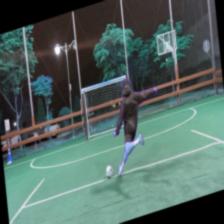

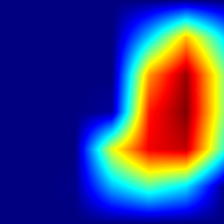

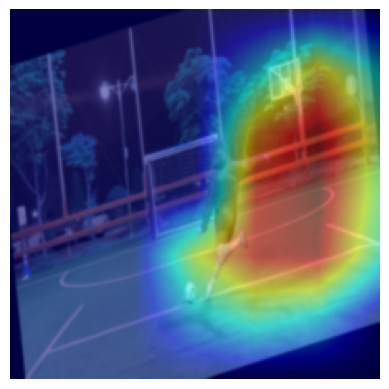

In [28]:
grad_cam = GradCam(model= resnet_model, target_layer = target_layer)
mask = grad_cam(example, None)
show_cam_on_image(trans_example, mask)
np_example = np.array(trans_example)
overlaid_image = overlay_heatmap(np_example, mask)
plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

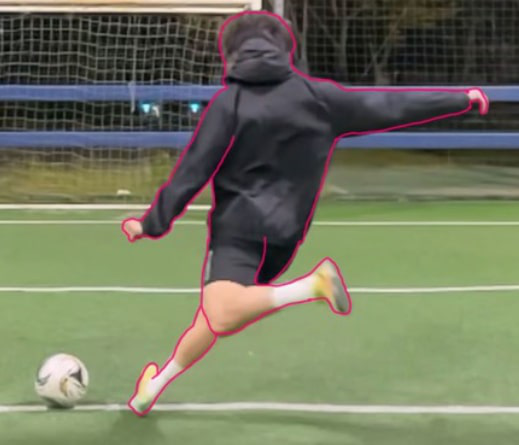

In [39]:
image_path = "/content/drive/MyDrive/Colab_Notebooks/ML_2023/data/images/crop.jpg"  # 이미지 파일 경로
crop_image = Image.open(image_path)
crop_image

In [40]:
crop_image = crop_image.convert("RGB")
temp_image = transform(crop_image)
crop_image = ToTensor()(temp_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


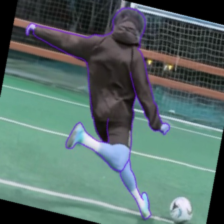

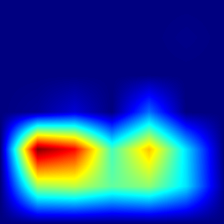

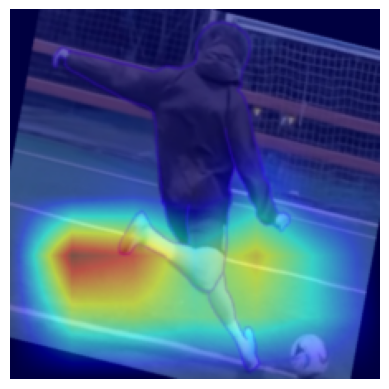

In [42]:
grad_cam = GradCam(model= resnet_model, target_layer = target_layer)
mask = grad_cam(crop_image, None)
show_cam_on_image(temp_image, mask)
np_crop = np.array(temp_image)
overlaid_image = overlay_heatmap(np_crop, mask)
plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()